In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time

from pymongo import MongoClient
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.contrib.slim import fully_connected as fc

from ThemeSeacher import Updator, clean, PhraserModel, tokenizer
from ThemeSeacher import KeywordDict, Model, Extractor
from ThemeSeacher import EmbeddingModel, Clustering


/home/qara/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Embedding default loaded


In [2]:
phraser = PhraserModel().get_phraser
dic = KeywordDict(phraser=phraser).get_dict

phraser_default.bin  loaded
keyword dictionary loaded


# Pickle Functions

In [3]:
def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def exist(name):
    return os.path.exists('obj/' + name + '.pkl')


In [49]:
total_data = load_obj('total_data')

In [20]:
total_data = total_data[total_data.date.apply(str)>='2018-05-01']

In [5]:
common_news = total_data[total_data.score==0]
hot_news = total_data[total_data.score>=1000]

In [64]:
idx = total_data.groupby(['date'])['score'].transform(max) == total_data['score']
top_news = total_data[idx].sort_values(by=['date'])
top_news = top_news.reset_index(drop=True)

# TF-IDF model

In [6]:
tfidf = Model(dic, name='bpc', smartirs='bpc', phraser=phraser).get_model

Model bpc loaded


In [7]:
phraser = PhraserModel().get_phraser

def sentence2keywords(title, topn=None):
    splitted = phraser[tokenizer([clean(title)])]
    scores = tfidf[dic.doc2bow(splitted[0])]
    keyword = []
    for idx, score in scores:
        keyword.append((tfidf.id2word[idx], score))
    keyword.sort(key=lambda k: k[1], reverse=True)
    
    if topn!=None:
        return keyword[:topn]
    else:
        return keyword

def words2keywords(words, topn=None):
    scores = tfidf[dic.doc2bow(words)]
    keyword = []
    for idx, score in scores:
        keyword.append((tfidf.id2word[idx], score))
    keyword.sort(key=lambda k: k[1], reverse=True)
    
    if topn!=None:
        return keyword[:topn]
    else:
        return keyword

phraser_default.bin  loaded


# Sentence Embedding

In [8]:
embedding = EmbeddingModel().get_embedding

Embedding default loaded


In [9]:
hot_news = hot_news.sort_values(by='date').reset_index(drop=True)
common_news = common_news.sort_values(by='date').reset_index(drop=True)
hot_news.head()

,date,score,title,lemmatized
0,2013-01-01,1096,planets oldest fossils at billion years old fo...,"[planet, old, fossil, year, old, find, australia]"
1,2013-01-01,2110,raped by men in days sixteen years later she a...,"[rap, man, day, year, later, await, justice, k..."
2,2013-01-01,2893,north korean leader in rare address seeks end ...,"[north, korean, leader, rare, address, seek, e..."
3,2013-01-02,1575,solar energy on the rise in germany the recent...,"[solar, energy, rise, germany, recent, solar, ..."
4,2013-01-02,2276,russia boosts space spending prime minister dm...,"[russia, boost, space, spend, prime_minister_d..."


In [10]:
startt = time.time()
def sentence_embedding(df):
    drop_list = []
    embedding_list = []
    for idx, row in df.iterrows():
        keywords = words2keywords(row.lemmatized)
        if len(keywords)==0:
            drop_list.append(idx)
            continue
        words, idf_scores = zip(*keywords)
        upscore = row['score']
        #upscore = np.log(row['score'])
        #upscore = 1 - np.power(np.e, -0.005*row['score'])

        ## normalize IDF score ##
        idf_scores = idf_scores/sum(idf_scores)

        avg_embedding = np.zeros(100, dtype=np.float32)
        for idx in range(len(words)):
            word = words[idx]
            idf = idf_scores[idx]
            embedding_vec = embedding[word]
            avg_embedding += idf*embedding_vec
        embedding_list.append(avg_embedding)
        
    df = df.drop(drop_list).reset_index(drop=True)
    
    print(len(embedding_list), len(df))
    assert len(df)==len(embedding_list)
    df['embed'] = pd.Series(embedding_list)
    print(time.time() - startt, 'sec')
    return df

In [67]:
top_news = sentence_embedding(top_news)

1768 1768
4173.05940246582 sec


/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [17]:
hot_news = sentence_embedding(hot_news)
common_news = sentence_embedding(common_news)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


22193 22193
37.53774905204773 sec
171541 171541
75.1589708328247 sec


# t-SNE

In [18]:
print(len(hot_news))
print(len(common_news))

22193
171541


In [19]:
new_df = np.array(list(hot_news.embed)+list(common_news.embed))

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(np.array(list(hot_news.embed)+list(common_news.embed)))

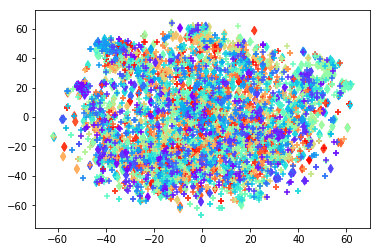

In [113]:
bs = len(new_df)
#colors = cm.rainbow(np.linspace(1, 0, bs))
colors_1 = cm.rainbow(np.linspace(1, 0, len(hot_news)))
colors_2 = cm.rainbow(np.linspace(1, 0, len(common_news)))
#colors = [(1, 0, 0) for i in range(1515)] + [(0, 1, 1) for i in range(2236)]

x1 = Y[:len(hot_news), 0]
y1 = Y[:len(hot_news), 1]
x2 = Y[len(hot_news):, 0]
y2 = Y[len(hot_news):, 1]
#plt.xlim(-80, 70)
#plt.ylim(-80, 70)
plt.scatter(x2, y2, color=colors_2, marker='+')
plt.scatter(x1, y1, color=colors_1, marker='d')
plt.show()

### Model

In [20]:
class VAE_2d(object):

    def __init__(self, n_z=2, learning_rate=1e-3, beta=100):
        self.learning_rate = learning_rate
        self.n_z = n_z
        self.beta = beta

        self.build()
        
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())

    # Build the netowrk and the loss functions
    def build(self):
        self.x = tf.placeholder(name='x', dtype=tf.float32, shape=[None, 100])

        # Encode
        # x -> z_mean, z_sigma -> z
        f1 = fc(self.x, 100, scope='enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 64, scope='enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 64, scope='enc_fc3', activation_fn=tf.nn.elu)
        f4 = fc(f3, 32, scope='enc_fc4', activation_fn=tf.nn.elu)
        f5 = fc(f4, 32, scope='enc_fc5', activation_fn=tf.nn.elu)
        f6 = fc(f5, 16, scope='enc_fc6', activation_fn=tf.nn.elu)
        f7 = fc(f6, 16, scope='enc_fc7', activation_fn=tf.nn.elu)
        f8 = fc(f7, 8, scope='enc_fc8', activation_fn=tf.nn.elu)
        f9 = fc(f8, 8, scope='enc_fc9', activation_fn=tf.nn.elu)
        f10 = fc(f9, 4, scope='enc_fc10', activation_fn=tf.nn.elu)
        self.z_mu = fc(f10, self.n_z, scope='enc_fc11_mu', activation_fn=None)
        self.z_log_sigma_sq = fc(f10, self.n_z, scope='enc_fc11_sigma', activation_fn=None)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=0.001, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        # Decode
        # z -> x_hat
        g1 = fc(self.z, 4, scope='dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 8, scope='dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 8, scope='dec_fc3', activation_fn=tf.nn.elu)
        g4 = fc(g3, 16, scope='dec_fc4', activation_fn=tf.nn.elu)
        g5 = fc(g4, 16, scope='dec_fc5', activation_fn=tf.nn.elu)
        g6 = fc(g5, 32, scope='dec_fc6', activation_fn=tf.nn.elu)
        g7 = fc(g6, 32, scope='dec_fc7', activation_fn=tf.nn.elu)
        g8 = fc(g7, 64, scope='dec_fc8', activation_fn=tf.nn.elu)
        g9 = fc(g8, 64, scope='dec_fc9', activation_fn=tf.nn.elu)
        g10 = fc(g9, 100, scope='dec_fc10', activation_fn=tf.nn.elu)
        self.x_hat = fc(g10, 100, scope='dec_fc11', activation_fn=None)

        # Loss
        # Reconstruction loss
        # Minimize the cross-entropy loss
        # H(x, x_hat) = -\Sigma x*log(x_hat) + (1-x)*log(1-x_hat)
        epsilon = 1e-10
        #'''
        recon_loss = tf.reduce_mean(tf.squared_difference(self.x_hat, self.x))
        '''
        recon_loss = -tf.reduce_sum(
            self.x * tf.log(epsilon+self.x_hat) + (1-self.x) * tf.log(epsilon+1-self.x_hat),
            axis=1
        )
        #'''
        self.recon_loss = tf.reduce_mean(recon_loss)

        # Latent loss
        # Kullback Leibler divergence: measure the difference between two distributions
        # Here we measure the divergence between the latent distribution and N(0, 1)
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = tf.reduce_mean(latent_loss)

        self.total_loss = tf.reduce_mean(recon_loss + self.beta * latent_loss)
        self.train_op = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate).minimize(self.total_loss)
        return

    # Execute the forward and the backward pass
    def run_single_step(self, x):
        _, loss, recon_loss, latent_loss = self.sess.run(
            [self.train_op, self.total_loss, self.recon_loss, self.latent_loss],
            feed_dict={self.x: x}
        )
        return loss, recon_loss, latent_loss

    # x -> x_hat
    def reconstructor(self, x):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.x: x})
        return x_hat

    # z -> x
    def generator(self, z):
        x_hat = self.sess.run(self.x_hat, feed_dict={self.z: z})
        return x_hat

    # x -> z
    def transformer(self, x):
        z = self.sess.run(self.z, feed_dict={self.x: x})
        return z
    
    def restore(self, saver, ckpt):
        saver.restore(self.sess, ckpt)

In [21]:
model_name = 'final/mg2_200'

tf.reset_default_graph()
model = VAE_2d(n_z=4, learning_rate=1e-4, beta=0.01)
saver = tf.train.Saver()
model.restore(saver, './ckpt/%s.ckpt' %model_name)

INFO:tensorflow:Restoring parameters from ./ckpt/final/mg2_200.ckpt


In [74]:
new_df = load_obj('new_embedding')

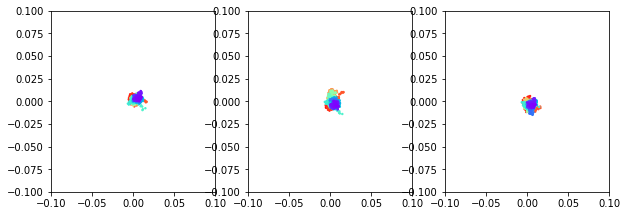

				  Average Log


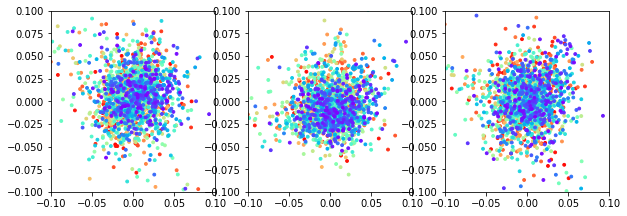

				   Top News


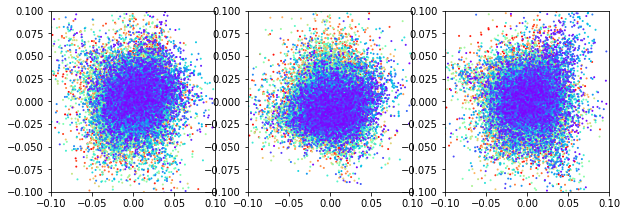

			      Hot News: ups>1000


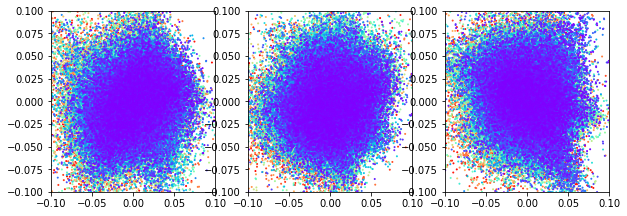

			      Common News: ups==0


In [107]:
size=10

# avg log embedding
x = model.transformer(np.array(list(new_df.avg_embed_log)))
colors = cm.rainbow(np.linspace(1, 0, len(x)))
fig, ax = plt.subplots(1, model.n_z - 1, figsize=(size,size/(model.n_z-1)))
x1 = x[:, 0]
for idx in range(1, model.n_z):
    y1 = x[:, idx]
    ax[idx-1].set_xlim(-0.1, 0.1)
    ax[idx-1].set_ylim(-0.1, 0.1)
    ax[idx-1].scatter(x1, y1, color=colors, s=2)

plt.show()
print('\t\t\t\t  Average Log')

# top news : top news per day
x = model.transformer(np.array(list(top_news.embed)))
colors = cm.rainbow(np.linspace(1, 0, len(x)))
fig, ax = plt.subplots(1, model.n_z - 1, figsize=(size,size/(model.n_z-1)))
x1 = x[:, 0]
for idx in range(1, model.n_z):
    y1 = x[:, idx]
    ax[idx-1].set_xlim(-0.1, 0.1)
    ax[idx-1].set_ylim(-0.1, 0.1)
    ax[idx-1].scatter(x1, y1, color=colors, s=8)

plt.show()
print('\t\t\t\t   Top News')

# hot news : upcount > 1000
x = model.transformer(np.array(list(hot_news.embed)))
colors = cm.rainbow(np.linspace(1, 0, len(x)))
fig, ax = plt.subplots(1, model.n_z - 1, figsize=(size,size/(model.n_z-1)))
x1 = x[:, 0]
for idx in range(1, model.n_z):
    y1 = x[:, idx]
    ax[idx-1].set_xlim(-0.1, 0.1)
    ax[idx-1].set_ylim(-0.1, 0.1)
    ax[idx-1].scatter(x1, y1, color=colors, s=1)

plt.show()
print('\t\t\t      Hot News: ups>1000')

# common news : upcount = 0
x = model.transformer(np.array(list(common_news.embed)))
colors = cm.rainbow(np.linspace(1, 0, len(x)))
fig, ax = plt.subplots(1, model.n_z - 1, figsize=(size,size/(model.n_z-1)))
x1 = x[:, 0]
for idx in range(1, model.n_z):
    y1 = x[:, idx]
    ax[idx-1].set_xlim(-0.1, 0.1)
    ax[idx-1].set_ylim(-0.1, 0.1)
    ax[idx-1].scatter(x1, y1, color=colors, s=1)

plt.show()
print('\t\t\t      Common News: ups==0')